In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.lines as lines

#import seaborn as sns
#sns.set(style='ticks')

params = {'legend.fontsize': 'x-large',
         'figure.figsize': (15,5),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
#open the csv file for miles
filename = 'MiniMiles.csv'

#get the data
mdata = pd.read_csv(filename,skiprows=0)

###Convert Datetime to format
mdata['dtime'] = pd.to_datetime(mdata.dtime,format='%Y-%m-%d %H:%M:%S')
mdata['miles_int'] = 0

nentries = len(mdata)
Miles0 = mdata.miles.min()
for i in range(1,nentries):
    mdata.miles_int.loc[i] = mdata.miles.loc[i]-mdata.miles.loc[i-1]

#mdata['mymiles'] = mdata.miles -mdata.miles[0]
#mdata['dTime'] = mdata.Data + ' ' 

### get the gas data
gfilename = 'GasRefills.csv'

gdata = pd.read_csv(gfilename)
gdata['gtime'] = pd.to_datetime(gdata.gtime,format='%Y-%m-%d %H:%M:%S')

def add_time_miles(month,day,year,hour,minute, miles):
    newdate = datetime(year, month, day, hour, minute)
    nentries = len(mdata)
    diff = miles - mdata.miles.loc[nentries-1]
    if miles < Miles0:
        print("less miles thatn the initial miles (%d), not adding entry" %Miles0)
        return;
    if diff < 0:
        print("same or lower milege (%d) as previous entry: %d, not adding point" % (miles,mdata.miles.loc[nentries-1]))
        return;
    
    
    print ('Added entry %s, %d' % (newdate, miles))
    mdata.loc[nentries] =[pd.to_datetime(newdate),miles,diff]
    return;

def add_miles(miles):
    now = datetime.now()
    add_time_miles(now.month, now.day, now.year,now.hour, now.minute, miles)
    return;
    
def add_gas(gallons,price):
    nd = datetime.now()
    add_time_gas(nd.month, nd.day, nd.year, nd.hour,nd.minute,gallons, price)
    return;

def add_time_gas(month,day,year,hour,minute, gallons, price):
    newdate = datetime(year, month, day, hour, minute)
    nentries = len(gdata)
        
    gdata.loc[nentries] =[pd.to_datetime(newdate),gallons, price]
    return;

def save_miles():
    mdata.to_csv('MiniMiles.csv',sep=',',encoding='utf-8', index=False,columns=['dtime','miles'])
    return;

def save_gas():
    gdata.to_csv('GasRefills.csv',sep=',',encoding='utf-8', index=False,columns=['gtime','gallons','price'])
    return;

# Add miles or gas data

In [12]:
#add_time_miles(month, day, year, hour, minutes, miles)
# or add_miles(miles) to add using today's timestamp
#add_time_miles(1,11,2018,19,32,4742)
add_miles(4772)
mdata.tail()

Added entry 2018-01-14 08:23:00, 4772


,dtime,miles,miles_int
38,2018-01-11 09:22:00,4727,16
39,2018-01-11 19:32:00,4742,15
40,2018-01-12 18:14:00,4772,30
41,2018-01-13 21:43:00,4772,0
42,2018-01-14 08:23:00,4772,0


In [9]:
#add_time_gas(month, day, year,hour, minutes, gallons, price)
#add_gas(gallons, price)   this will add data with todays date
#add_gas(12,18,2017,10,0)
#add_gas(12.888,30.92)

In [5]:
gdata.tail()

,gtime,gallons,price
0,2017-12-18 00:00:00,10.000,0.00
1,2018-01-09 09:30:00,12.888,30.92


## Save the csv data file

In [16]:
save_miles()

In [11]:
save_gas()

# Process the data

Resample the data by day 'D', get the total number of miles driven per day, and cumulative miles driven.

In [13]:
#Get the Series data with time as an index
dt1 = pd.Series(mdata.miles_int.tolist(), index=mdata.dtime)
dt2 = pd.Series(mdata.miles.tolist(), index=mdata.dtime)

#resample the data by day, later it can be by week, or business day
max_m = dt2.resample('D').max()-Miles0;
mpday = dt1.resample('D').sum();

#merge the series into a dataframe
mpd1 = pd.DataFrame(data=mpday.values,columns=['mpd'])
mpd2 = pd.DataFrame(data=mpday.index,columns=['dtime'])
max1 = pd.DataFrame(data=max_m.values,columns=['max_miles'])
mpdt = pd.merge(mpd2,mpd1,left_index=True, right_index=True);

mpd = mpdt.merge(max1,left_index=True,right_index=True)

#gas data
NGas = len(gdata)

Get the miles per gallon of gas added

In [14]:
#miles per gallon of gas
gdata['mpergal'] = 0
NGas = len(gdata)
for i in range(1,NGas):
    mpg = mpd[(mpd.dtime>= gdata.gtime.loc[i-1]) & (mpd.dtime< gdata.gtime.loc[i])]
    #miles in the period
    gdata.mpergal.loc[i] = mpg.mpd.sum()/gdata.gallons.loc[i]
    #print(i)
gdata.head()   

,gtime,gallons,price,mpergal
0,2017-12-18 00:00:00,10.000,0.00,0.000000
1,2018-01-09 09:30:00,12.888,30.92,31.114215


# Plot the miles vs time

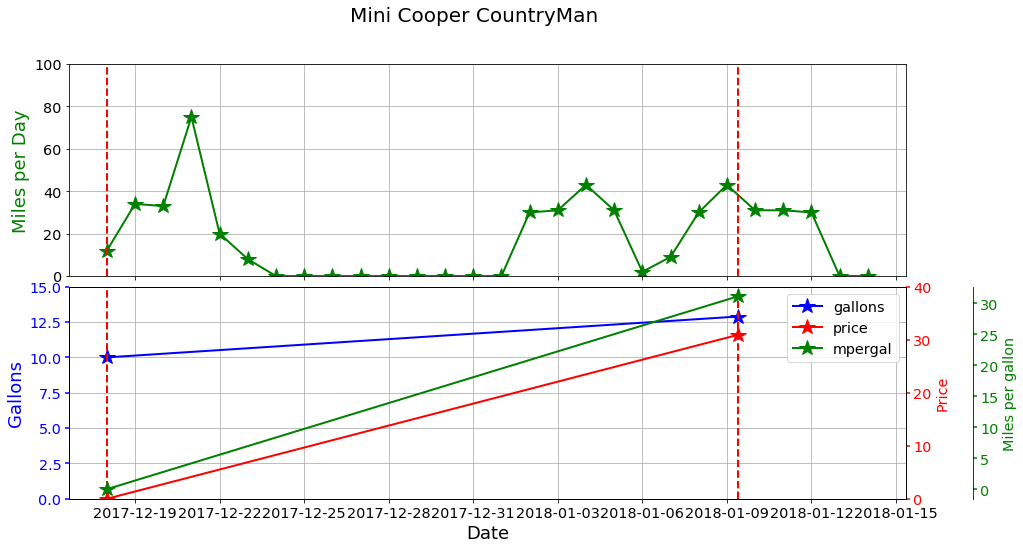

In [15]:
fig, ax1 = plt.subplots(2,sharex=True,figsize=(15,8))
#ax2 = ax1.twinx()
fig.suptitle('Mini Cooper CountryMan',fontsize=20)
ax1[0].plot(mpd.dtime, mpd.mpd,'g*-',linewidth=2,ms=16 )
#ax1[1].plot(mpd.dtime, mpd.max_miles-Miles0,'b*-',linewidth=2,ms=16)

p1,= ax1[1].plot(gdata.gtime, gdata.gallons,'b*-',linewidth=2,ms=16)
ax2 = ax1[1].twinx()
ax3 = ax1[1].twinx()


ax3.spines["right"].set_position(("axes", 1.08))
ax3.spines["right"].set_visible(True)

p2, = ax2.plot(gdata.gtime, gdata.price, 'r*-',linewidth=2,ms=16)
ax2.set_ylabel('Price', color='r')
#ax3.spines["right"].set_position(("axes", 1.2)
                                 
p3, = ax3.plot(gdata.gtime, gdata.mpergal,'g*-',linewidth=2,ms=16)
ax3.set_ylabel('Miles per gallon',color='g')

#
#set the titles
ax1[0].set_ylabel('Miles per Day', color ='g',fontsize=18)
ax1[1].set_ylabel('Gallons', color ='b',fontsize=18)
ax1[1].set_xlabel('Date',fontsize=18)
ax1[0].grid(True)
ax1[1].grid(True)

#set the colors
tkw = dict(size=4, width=1.5)
ax1[1].tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)


ax1[0].set_ylim(0,100)
ax1[1].set_ylim(0,15)
ax2.set_ylim(0,40)
fig.subplots_adjust(hspace=.05)


##
#line = lines.Line2D([gdata.gtime[0], 15], [gdata.gtime[0], 35], lw=2, color='red', axes=ax1[0])
#ax1[0].add_line(line)
#l1=plt.axhline(50,color='red',ls='-')
for i in range(NGas):
    ax1[0].axvline(gdata.gtime[i], color='r', linestyle='--', lw=2)
    ax1[1].axvline(gdata.gtime[i], color='r', linestyle='--', lw=2)

    
lines = [p1, p2, p3]
ax1[1].legend(lines, [l.get_label() for l in lines])


plt.show()

Text(0.5,1,'Mini Country')

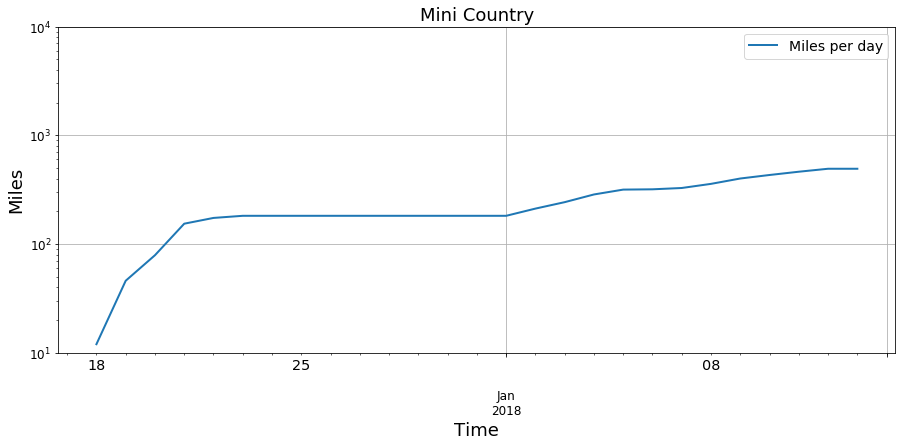

In [7]:
fig = plt.figure(2)
mpd.plot(x='dtime',y='max_miles',figsize=(15,6),grid=True,kind='line',
         label='Miles per day',linewidth=2,title='Miles per day',ylim=(1e1,1e4))
plt.ylabel('Miles',fontsize=18)
plt.xlabel('Time',fontsize = 18)
plt.semilogy()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
#plt.savefig('Thermal_Profile//Temperature_1.png')
plt.title('Mini Country',fontsize=18)


#slope, intercept, r_value, p_value, std_err = stats.linregress(mpd.dtime,mpd.max_miles)

In [ ]:
#Plot miles per trip
#gdata.gtime[0]
#fig = plt.figure(1)
#mdata[mdata.miles_int >0].plot(x='dtime',y='miles_int',figsize=(15,10),grid=True,label='Miles per trip')

In [9]:
#open the csv file for miles
filename = 'MiniMiles.csv'

#get the data
mdata2 = pd.read_csv(filename,skiprows=0)
mdata2.index
###Convert Datetime to format
#mdata['dtime'] = pd.to_datetime(mdata.dtime,format='%Y-%m-%d %H:%M:%S')
#mdata['miles_int'] = 0

RangeIndex(start=0, stop=42, step=1)

In [10]:
m2 =mpd.set_index('dtime')
m2.tail()

,mpd,max_miles
dtime,,
2018-01-09,43,401
2018-01-10,31,432
2018-01-11,31,463
2018-01-12,30,493
2018-01-13,0,493


Text(24.625,0.5,'Miles')

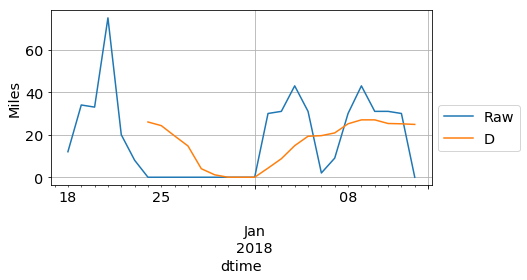

In [11]:
m2.mpd.plot(label='Raw',grid=True)
m2.mpd.rolling(7).mean().plot(label='D')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Miles")